In [42]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("TweebankNLP/bertweet-tb2-ner")

model = AutoModelForTokenClassification.from_pretrained("TweebankNLP/bertweet-tb2-ner")


In [43]:
from transformers import pipeline

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "Paul Walkers Fast and Furious car sells for 555,000 at auction"

ner_results = nlp(example)

In [44]:
ner_results

[{'entity': 'B-PER',
  'score': 0.93847704,
  'index': 1,
  'word': 'Paul',
  'start': None,
  'end': None},
 {'entity': 'I-PER',
  'score': 0.9025324,
  'index': 2,
  'word': 'Wal@@',
  'start': None,
  'end': None},
 {'entity': 'I-MISC',
  'score': 0.8081255,
  'index': 3,
  'word': 'kers',
  'start': None,
  'end': None},
 {'entity': 'B-MISC',
  'score': 0.8930911,
  'index': 4,
  'word': 'Fast',
  'start': None,
  'end': None},
 {'entity': 'I-MISC',
  'score': 0.92013896,
  'index': 5,
  'word': 'and',
  'start': None,
  'end': None},
 {'entity': 'I-MISC',
  'score': 0.92504215,
  'index': 6,
  'word': 'Furious',
  'start': None,
  'end': None}]

In [45]:
def merge_subwords(ner_results):
    merged_entities = []
    current_entity = None

    for result in ner_results:
        word = result['word'].replace('@@', '')  # Remove subword markers
        entity = result['entity']

        if entity.startswith('B-'):  # Beginning of a new entity
            if current_entity:
                merged_entities.append(current_entity)
            current_entity = {'entity': entity[2:], 'words': [word], 'score': result['score']}
        elif entity.startswith('I-') and current_entity:  # Inside an existing entity
            current_entity['words'].append(word)
            current_entity['score'] = max(current_entity['score'], result['score'])  # Use the highest score
        else:  # Outside of any entity
            if current_entity:
                merged_entities.append(current_entity)
                current_entity = None

    if current_entity:
        merged_entities.append(current_entity)

    # Convert the merged entities to a more readable format
    readable_entities = [{'entity': entity['entity'], 'name': ''.join(entity['words']), 'score': entity['score']}
                         for entity in merged_entities]

    return readable_entities

# Example usage
merged_ner_results = merge_subwords(ner_results)
print(merged_ner_results)


[{'entity': 'PER', 'name': 'PaulWalkers', 'score': 0.93847704}, {'entity': 'MISC', 'name': 'FastandFurious', 'score': 0.92504215}]


In [53]:
ner_results = merged_ner_results

In [54]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests


In [55]:
url = "https://www.nme.com/wp-content/uploads/2021/06/Paul-Walker-in-The-Fast-Furious-2001.jpg"


In [56]:
image = Image.open(requests.get(url, stream=True).raw)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

In [57]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [58]:
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

In [59]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected person with confidence 1.0 at location [464.59, 88.76, 1244.01, 1255.96]
Detected car with confidence 0.996 at location [43.54, 88.06, 1831.26, 1201.72]


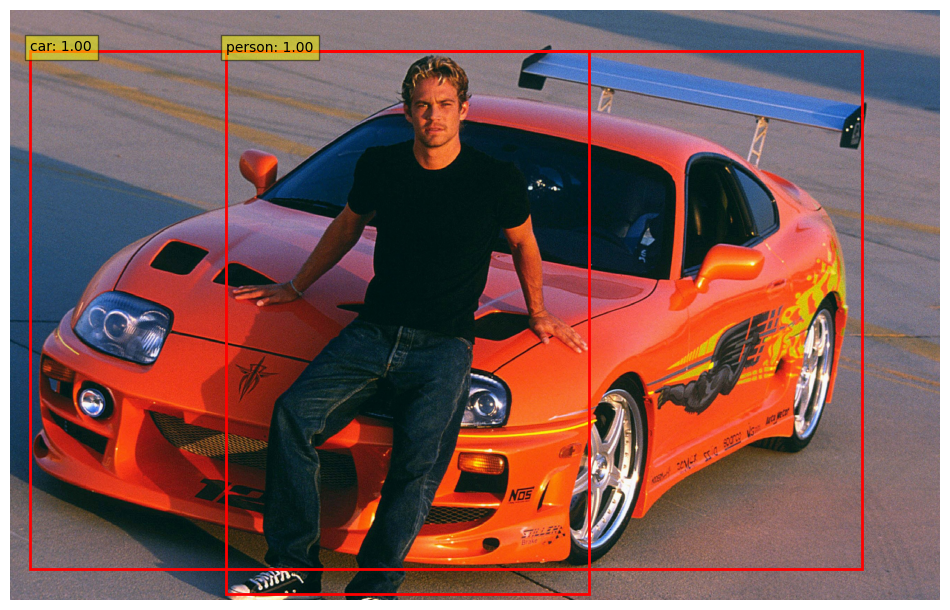

In [60]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    label_name = model.config.id2label[label.item()]
    box = box.detach().numpy()
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], f"{label_name}: {score:.2f}", bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis("off")
plt.show()


In [61]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [66]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

ner_classes = [result['entity'] for result in ner_results]

detected_objects = [model.config.id2label[label.item()] for label in results["labels"]]



In [67]:
ner_names = [result['name'] for result in ner_results]

ner_embeddings = sbert_model.encode(ner_names)
object_embeddings = sbert_model.encode(detected_objects)

similarity_matrix = cosine_similarity(ner_embeddings, object_embeddings)

# Find the most similar pairs
for i, ner_name in enumerate(ner_names):
    most_similar_index = np.argmax(similarity_matrix[i])
    most_similar_object = detected_objects[most_similar_index]
    similarity_score = similarity_matrix[i][most_similar_index]
    print(f"{ner_name} is most similar to {most_similar_object} with a similarity score of {similarity_score:.2f}")

PaulWalkers is most similar to person with a similarity score of 0.21
FastandFurious is most similar to car with a similarity score of 0.22


In [69]:
ner_results

[{'entity': 'PER', 'name': 'PaulWalkers', 'score': 0.93847704},
 {'entity': 'MISC', 'name': 'FastandFurious', 'score': 0.92504215}]

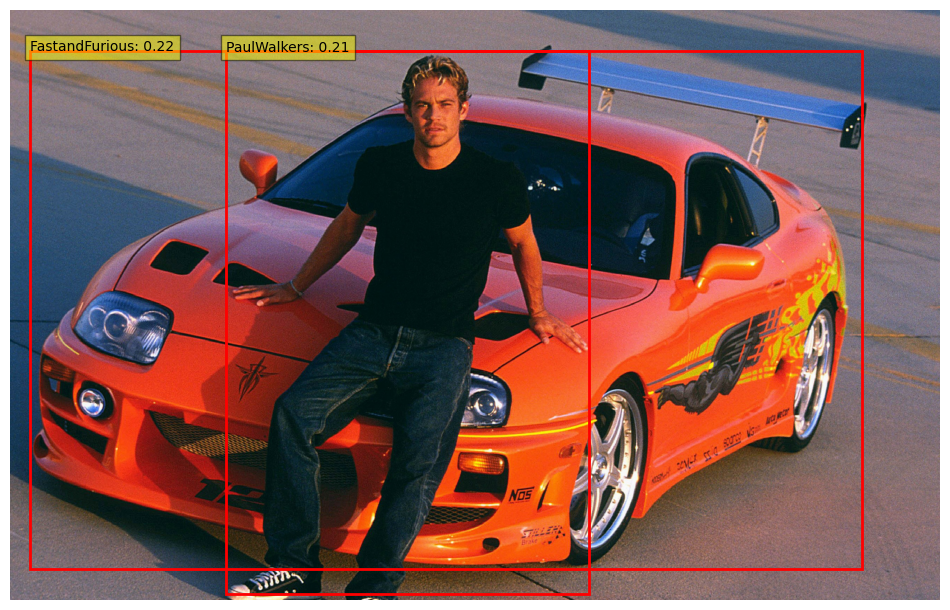

In [72]:
ner_names = [result['name'] for result in ner_results]

detected_objects = [model.config.id2label[label.item()] for label in results["labels"]]

ner_embeddings = sbert_model.encode(ner_names)
object_embeddings = sbert_model.encode(detected_objects)

similarity_matrix = cosine_similarity(ner_embeddings, object_embeddings)

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for i, (score, label, box) in enumerate(zip(results["scores"], results["labels"], results["boxes"])):
    label_name = model.config.id2label[label.item()]
    box = box.detach().numpy()
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    most_similar_index = np.argmax(similarity_matrix[:, i])
    mapped_class = ner_names[most_similar_index]
    similarity_score = similarity_matrix[most_similar_index, i]
    
    ax.text(box[0], box[1], f"{mapped_class}: {similarity_score:.2f}", bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis("off")
plt.show()